# World Wide Products Inc.

TODO Write intro

## Retrieving the Data
This data comes from the [Forecasts for Product Demand dataset on Kaggle](https://www.kaggle.com/felixzhao/productdemandforecasting). We will begin by loading the dataset into a dataframe:

In [1]:
from os import path
import numpy as np
import pandas as pd

product_demand_df = pd.read_csv("data/raw/Historical Product Demand.csv")
product_demand_df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


Let's run through some quick information about this dataset:

In [2]:
product_demand_df.shape

(1048575, 5)

In [3]:
product_demand_df.keys()

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

In order to effectively use this dataset, let's analyze the columns:

|Key              |Description|
|:----------------|:----------|
|Product_Code     |Product name, encoded|
|Warehouse        |Warehouse name, encoded|
|Product_Category |Category for each product, encoded|
|Date             |Date customer needs the product|
|Order_Demand     |Single order quantity|

## Cleaning Up the Data
There are some very simple things we can do to start cleaning the data. First, let's make the columns lowercase, just for consistency sake:

In [4]:
product_demand_df.columns = map(str.lower, product_demand_df.columns)
product_demand_df.keys()

Index(['product_code', 'warehouse', 'product_category', 'date',
       'order_demand'],
      dtype='object')

Let's check for any missing values:

In [5]:
product_demand_df[product_demand_df.isna().any(axis=1)]

,product_code,warehouse,product_category,date,order_demand
45460,Product_1461,Whse_A,Category_019,NaN,10000
456373,Product_1636,Whse_A,Category_019,NaN,100
456374,Product_1461,Whse_A,Category_019,NaN,300
456375,Product_1464,Whse_A,Category_019,NaN,300
456376,Product_1388,Whse_A,Category_019,NaN,200
...,...,...,...,...,...
995790,Product_1464,Whse_A,Category_019,NaN,(900)
995791,Product_1541,Whse_A,Category_019,NaN,(200)
995792,Product_1388,Whse_A,Category_019,NaN,(300)
995793,Product_1541,Whse_A,Category_019,NaN,(300)


It looks like we have a bunch of missing dates. Because we are doing time series forecasting, we require a date. Let's go ahead and drop all of these data points, as they are unusable to us.

In [6]:
indices_to_drop = product_demand_df[product_demand_df.isna().any(axis=1)].index
product_demand_df.drop(indices_to_drop, inplace=True)

Next, let's convert all of the information in `product_code`, `warehouse`, and `product_category` to integers:

In [7]:
unique_products = product_demand_df["product_code"].unique()
product_ordinal = {v: k for k, v in dict(enumerate(unique_products.flatten(), 1)).items()}
product_demand_df["product_code_ordinal"] = product_demand_df["product_code"].apply(lambda p: product_ordinal[p])

unique_warehouses = product_demand_df["warehouse"].unique()
warehouse_ordinal = {v: k for k, v in dict(enumerate(unique_warehouses.flatten(), 1)).items()}
product_demand_df["warehouse_ordinal"] = product_demand_df["warehouse"].apply(lambda w: warehouse_ordinal[w])

unique_categories = product_demand_df["product_category"].unique()
category_ordinal = {v: k for k, v in dict(enumerate(unique_categories.flatten(), 1)).items()}
product_demand_df["product_category_ordinal"] = product_demand_df["product_category"].apply(lambda c: category_ordinal[c])

product_demand_df.head()

,product_code,warehouse,product_category,date,order_demand,product_code_ordinal,warehouse_ordinal,product_category_ordinal
0,Product_0993,Whse_J,Category_028,2012/7/27,100,1,1,1
1,Product_0979,Whse_J,Category_028,2012/1/19,500,2,1,1
2,Product_0979,Whse_J,Category_028,2012/2/3,500,2,1,1
3,Product_0979,Whse_J,Category_028,2012/2/9,500,2,1,1
4,Product_0979,Whse_J,Category_028,2012/3/2,500,2,1,1


We also have an issue with our `order_demand` values. They are stored as strings, and almost all have something wrong with them:

In [8]:
# Prints all demands that are not numeric strings
product_demand_df["order_demand"][~product_demand_df["order_demand"].str.isnumeric()].shape

(1037336,)

**1037336** of our order demand values are in string form, rather than integers! Let's change that:

In [10]:
import re

# Extract all integers and save them
product_demand_df["order_demand"] = product_demand_df["order_demand"].apply(lambda x: int(re.findall(r"\d+", x)[0]))

TypeError: expected string or bytes-like object

Finally, let's convert all dates to `datetime` objects. From taking a look at the `date` values in the previous statement, it looks like the pattern is "_year/month/day_":

In [11]:
product_demand_df["date"] = pd.to_datetime(product_demand_df["date"], format="%Y/%m/%d")
product_demand_df["date"].describe()

count                 1037336
unique                   1729
top       2013-09-27 00:00:00
freq                     2075
first     2011-01-08 00:00:00
last      2017-01-09 00:00:00
Name: date, dtype: object

## Feature Engineering
To predict the demad of a specific product, we should make some new features that make that job easier. To do this, let's organize things by `product`, and create a new feature that specifies the `demand_per_month`. Then, we will organize by `product_category`, and do the same thing to see if we get better results.

To start, let's split the date into a `months_since_start` integer to make `demand_per_month` calculations easier:

In [12]:
date_start = product_demand_df["date"].min()
print("Start date - %s/%s" % (date_start.year, date_start.month))

product_demand_df["months_since_start"] = product_demand_df["date"]\
    .apply(lambda date: ((date.year - date_start.year) * 12) + (date.month - date_start.month))
product_demand_df.drop(columns=["date"], inplace=True)
product_demand_df.head()

Start date - 2011/1


,product_code,warehouse,product_category,order_demand,product_code_ordinal,warehouse_ordinal,product_category_ordinal,months_since_start
0,Product_0993,Whse_J,Category_028,100,1,1,1,18
1,Product_0979,Whse_J,Category_028,500,2,1,1,12
2,Product_0979,Whse_J,Category_028,500,2,1,1,13
3,Product_0979,Whse_J,Category_028,500,2,1,1,13
4,Product_0979,Whse_J,Category_028,500,2,1,1,14


Now let's do the per month calculations:

In [13]:
demand_products_df = product_demand_df[["product_code_ordinal", "months_since_start", "order_demand"]]\
    .groupby(["months_since_start", "product_code_ordinal"])["order_demand"].sum().reset_index()

demand_categories_df = product_demand_df[["product_category_ordinal", "months_since_start", "order_demand"]]\
    .groupby(["months_since_start", "product_category_ordinal"])["order_demand"].sum().reset_index()

In [14]:
demand_products_df.head()

,months_since_start,product_code_ordinal,order_demand
0,0,45,2
1,4,1255,108
2,5,49,92000
3,8,153,5
4,8,440,1250


In [15]:
demand_categories_df.head()

,months_since_start,product_category_ordinal,order_demand
0,0,2,2
1,4,18,108
2,5,4,92000
3,8,3,28
4,8,4,1250


## Analysis
Let's start analyzing some data. Let's start by visualizing the purchases:

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

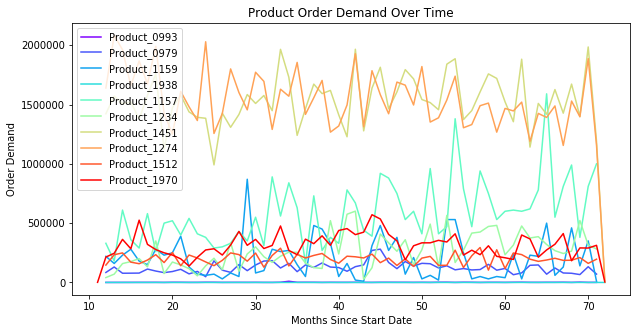

In [17]:
plt.figure(figsize=(10, 5))

num_products_shown = 10

data = demand_products_df.groupby(["product_code_ordinal"])\
    .apply(lambda row: np.array(list(zip(row["months_since_start"], row["order_demand"]))))
data = np.array(list(data[:num_products_shown]))

colors = cm.rainbow(np.linspace(0, 1, num_products_shown))
i = 0
for d in data:
    plt.plot(d[:, 0], d[:, 1], color=colors[i], label=unique_products[i])
    i += 1
plt.title("Product Order Demand Over Time")
plt.xlabel("Months Since Start Date")
plt.ylabel("Order Demand")
plt.legend()

plt.show()

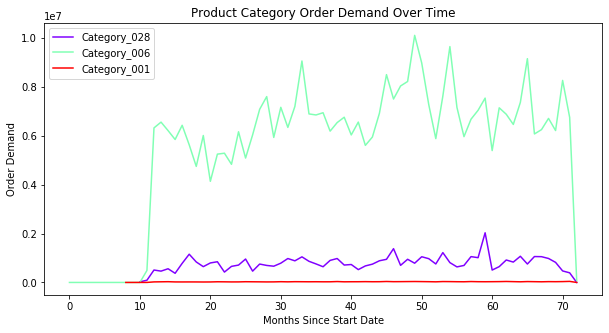

In [18]:
plt.figure(figsize=(10, 5))

num_categories_shown = 3
data = demand_categories_df.groupby(["product_category_ordinal"])\
    .apply(lambda row: np.array(list(zip(row["months_since_start"], row["order_demand"]))))
data = np.array(list(data[:num_categories_shown]))

colors = cm.rainbow(np.linspace(0, 1, num_categories_shown))
i = 0
for d in data:
    plt.plot(d[:, 0], d[:, 1], color=colors[i], label=unique_categories[i])
    i += 1
plt.title("Product Category Order Demand Over Time")
plt.xlabel("Months Since Start Date")
plt.ylabel("Order Demand")
plt.legend()

plt.show()

Because it seems that `product_category` is more stable, we will look at that to do our forecasting:

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

labels = product_demand_df["order_demand"]
test_size = 0.20 # Test size is 20% of all rows
features = product_demand_df[["product_code_ordinal", "warehouse_ordinal", "product_category_ordinal"]]
training_f, testing_f, training_l, testing_l = train_test_split(features, labels, test_size=test_size)

#### Gradient Boosting

In [46]:
grad_boost = GradientBoostingRegressor()
grad_boost.fit(training_f, training_l)
prediction = grad_boost.predict(testing_f)
grad_boost_accuracy = grad_boost.score(testing_f, testing_l)

0.17547113707940043

#### Neural Network

In [48]:
nn = MLPRegressor(max_iter=100)
nn.fit(training_f, training_l)
prediction = nn.predict(testing_f)
nn.score(testing_f, testing_l)

C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.0479564169770722